### Prediction (estimating state value function of a policy) when MDP is not known
 - First visit Monte Carlo (FVMC)
 - Every visit MC (EVMC)
 - TD(0)
 - TD($\lambda$)
 
*Again we will use FrozenLake 8x8  stochastic environment*
 

### First visit Monte Carlo (FVMC)
- For ep in range(num_episode), do
    - Roll out complete trajectory (till the e/o episode or horizon), trajectory is a sequence of tuples
    $$ (S_{t},A_{t},R_{t+1}), (S_{t+1},A_{t+1},R_{t+2}), .... (S_{T-1},A_{T-1},R_{T})$$
    - For each experience in the trajectory, do
        - check if the state is visited earlier, if yes then go to next experience in the trajectory (i.e use continue)
        - Otherwise, calculate the discounted return for this state , this will be the FVMC target for this state
        $$G_{t:T} = R_{t+1} + \gamma R_{t+2} + \gamma^{2}R_{t+3} + ....+ \gamma^{T-1}R_{T} $$
        - update the state value function for the state,s
        $$ V_{T}(S_{t}) = V_{T-1}(S_{t}) + \alpha_{t} (G_{t:T} - V_{T-1}(S_{t})) $$
        - NOTE: learning rate $\alpha$ can be constant or time varying

In [5]:
import gym
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

np.random.seed(0)

In [6]:
env = gym.make("FrozenLake8x8-v0")

In [9]:
def gen_trajectory(pi, env, maxsteps):
    '''
    [1] pi: policy
    [2] env: environment
    [3] maxsteps: maximum number of steps to be taken
    '''
    done = False
    stepcount = 0
    s = env.reset()
    trajectory = []
    while not done:
        stepcount += 1
        next_state, reward, done, info = env.step(pi[s])
        experience = (s, pi[s], reward, next_state, done)
        trajectory.append(experience)
        if done or stepcount >= maxsteps:
            break
        s = next_state
    return trajectory

In [10]:
def learningrate_schedule(start_alpha, min_alpha, max_episodes):
    '''
    [1] start_alpha :learning rate at the start of episode
    [2] min_alpha: minimum learning rate
    [3] max_episodes: maximum number of episodes
    '''    
    t = np.arange(0,max_episodes)
    alpha_s, alpha_f  = start_alpha, min_alpha
    assert max_episodes > 1
    alpha_sch = alpha_s * (alpha_f/alpha_s)**(t/(max_episodes-1))
    return alpha_sch
test = 0
if test==1:
    alpha_sch = learningrate_schedule(start_alpha=0.6, min_alpha=0.1, max_episodes=1000)
    plt.figure()
    plt.plot(alpha_sch)

In [7]:
def MC_prediction(pi, env, gamma=1.0, start_alpha=0.5, min_alpha=0.1, max_episodes=1000, maxsteps=200, first_visit=True):
    '''
    [1] pi: policy which needs to be evaluated
    [2] env: environment
    [3] gamma: discount factor
    [4] min_alpha: minimum learning rate
    [5] max_episodes: maximum episodes for MC
    [6] maxsteps: maximum number of steps for trajectory generation
    [7] first_visit: boolean flag to indicate First Visit version of MC prediction
    '''
    nS = len(pi)
    V = np.zeros(nS)
    V_track = np.zeros((max_episodes, nS)) # value function snapshot  for every episode, just for vis purpose
    
    # generate learning rate schedule 
    alpha_sch = learningrate_schedule(start_alpha, min_alpha, max_episodes) # this will be exponential decay schedule
    
    for ep in tqdm(range(max_episodes)):
        # generate trajectory
        trajectory = gen_trajectory(pi, env, maxsteps)
        visited = np.zeros(nS, dtype=np.bool) # reset the visited flag
        for t, experience in enumerate(trajectory):
            state, action, reward, next_state, _ = experience
            if visited[state]==1 and first_visit:
                continue
            visited[state] = True
            # compute the discounted return
            num_steps = len(trajectory[t:])
            gamma_seq = gamma**(np.arange(0,num_steps))
            #print(gamma_seq)
            #print(trajectory)
            #print(trajectory[t:])
            reward_list = np.array([experience[2] for experience in trajectory[t:]])
            returns = np.sum(gamma_seq * reward_list) #G_{t:T} = sum( gamma_seq * undiscounted returns )
            #print(returns)
            # update the state value 
            V[state] = V[state] + alpha_sch[ep] * (returns - V[state])
        # update V_track at the end of every episode
        V_track[ep,:] = V
        #print(f"episode :{ep}")
        
    return V, V_track, alpha_sch            

In [7]:
# converged policy taken from value iteration output of other notebook
pi = {0: 3,
 1: 2,
 2: 2,
 3: 2,
 4: 2,
 5: 2,
 6: 2,
 7: 2,
 8: 3,
 9: 3,
 10: 3,
 11: 3,
 12: 3,
 13: 3,
 14: 2,
 15: 1,
 16: 3,
 17: 3,
 18: 0,
 19: 0,
 20: 2,
 21: 3,
 22: 2,
 23: 2,
 24: 3,
 25: 3,
 26: 0,
 27: 1,
 28: 0,
 29: 0,
 30: 2,
 31: 2,
 32: 3,
 33: 3,
 34: 0,
 35: 0,
 36: 2,
 37: 1,
 38: 3,
 39: 2,
 40: 0,
 41: 0,
 42: 0,
 43: 1,
 44: 3,
 45: 0,
 46: 0,
 47: 2,
 48: 0,
 49: 0,
 50: 1,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 2,
 56: 0,
 57: 1,
 58: 0,
 59: 0,
 60: 1,
 61: 2,
 62: 1,
 63: 0}

In [19]:
V, V_track, alpha_sch = MC_prediction(pi, env, gamma=1.0, start_alpha=0.5, min_alpha=0.1, \
                                      max_episodes=1_00_000, maxsteps=200, first_visit=True)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:55<00:00, 569.83it/s]


In [20]:
V

array([0.84726467, 0.84726467, 0.82507051, 0.84568383, 0.82333522,
       0.82641548, 0.80247592, 0.77206907, 0.89211118, 0.87199503,
       0.81047915, 0.81981263, 0.8258231 , 0.82716269, 0.84669898,
       0.8367166 , 0.54719225, 0.66412603, 0.57221886, 0.        ,
       0.67614999, 0.65216787, 0.80371119, 0.83716981, 0.294185  ,
       0.54276224, 0.47042673, 0.32928365, 0.42565954, 0.        ,
       0.80496298, 0.84539764, 0.37387846, 0.52489542, 0.27604414,
       0.        , 0.48080822, 0.45938133, 0.80062694, 0.85356822,
       0.49226319, 0.        , 0.        , 0.07933763, 0.18942536,
       0.36654757, 0.        , 0.85894861, 0.49226319, 0.        ,
       0.0897472 , 0.02383495, 0.        , 0.38123116, 0.        ,
       0.95891577, 0.49226319, 0.3590764 , 0.23097714, 0.        ,
       0.        , 0.65373281, 0.87500939, 0.        ])

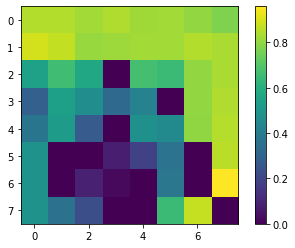

In [21]:
plt.figure()
plt.imshow(V.reshape(8,8))
plt.colorbar()

In [22]:
V_track

array([[0.5       , 0.5       , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.74999598, 0.74999598, 0.74999598, ..., 0.        , 0.        ,
        0.        ],
       [0.87499396, 0.87499396, 0.87499396, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.81143753, 0.81143753, 0.78403729, ..., 0.65373281, 0.87500939,
        0.        ],
       [0.83029408, 0.83029408, 0.8056339 , ..., 0.65373281, 0.87500939,
        0.        ],
       [0.84726467, 0.84726467, 0.82507051, ..., 0.65373281, 0.87500939,
        0.        ]])

In [23]:
mean, std = np.mean(V_track, axis=0),  np.std(V_track, axis=0)

<BarContainer object of 64 artists>

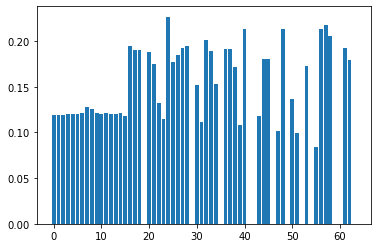

In [24]:
plt.figure()
plt.bar(np.arange(0,std.shape[0]), height=std)

### Temporal Difference (TD)
- MC requires to play the entire episode or some finite horizon
- MC has more variance but unbiased estimates
- TD on the other hand, bootstraps based on n-step estimates
- TD has lower variance but its estimates are biased since it bootstraps based on estimates
- TD does not require to play the entire episode till the end
- TD(0): bootstraps based on 1step
$$ V_{t+1}(S_{t}) = V_{t}(S_{t}) + \alpha_{t} (R_{t+1} + \gamma V_{t}(S_{t+1}) - V_{t}(S_{t})) $$

In [25]:
# This function is specifically written for TD(0), only one step ahead
# cell below has more generic implementation for  TD(n) for n steps ahead
def TD_prediction(pi, env, gamma=1.0, start_alpha=0.5, min_alpha=0.1, max_episodes=1000, nsteps=1):
    '''
    [1] pi: policy which needs to be evaluated
    [2] env: environment
    [3] gamma: discount factor
    [4] min_alpha: minimum learning rate
    [5] max_episodes: maximum episodes for MC
    [6] nsteps: number of steps in TD, if nsteps=1, then its is TD(0), nsteps=2, then it is TD(1) and so on...    
    '''
    nS = len(pi)
    V = np.zeros(nS)
    V_track = np.zeros((max_episodes, nS)) # value function snapshot  for every episode, just for vis purpose
    
    # generate learning rate schedule 
    alpha_sch = learningrate_schedule(start_alpha, min_alpha, max_episodes) # this will be exponential decay schedule
    
    for ep in tqdm(range(max_episodes)):
        state, done = env.reset(), False
        while not done:
            action = pi[state]
            next_state, reward, done, info = env.step(action)
            target = reward + gamma * V[next_state] * (not done)
            # update state value
            V[state] = V[state] + alpha_sch[ep] *(target - V[state])
            if done:
                break
            state = next_state
            
        V_track[ep,:] = V
              
                
    return V, V_track, alpha_sch    

In [30]:
def TD_prediction(pi, env, gamma=1.0, start_alpha=0.5, min_alpha=0.1, max_episodes=1000, nsteps=1):
    '''
    [1] pi: policy which needs to be evaluated
    [2] env: environment
    [3] gamma: discount factor
    [4] min_alpha: minimum learning rate
    [5] max_episodes: maximum episodes for MC
    [6] nsteps: number of steps in TD, if nsteps=1, then its is TD(0), nsteps=2, then it is TD(1) and so on...    
    '''
    nS = len(pi)
    V = np.zeros(nS)
    V_track = np.zeros((max_episodes, nS)) # value function snapshot  for every episode, just for vis purpose
    
    # generate learning rate schedule 
    alpha_sch = learningrate_schedule(start_alpha, min_alpha, max_episodes) # this will be exponential decay schedule
    
    for ep in tqdm(range(max_episodes)):
        state, done = env.reset(), False
        
        while not done:
            discounted_reward = 0.0
            experience = []
            # collect experience for n steps
            for i in range(nsteps):
                action = pi[state]
                next_state, reward, done, info = env.step(action)
                experience.append((state, action, reward, next_state, done))
                state = next_state
                                
                
            reward_list = np.array([exp[2] for exp in experience])  
            gamma_seq = gamma**(np.arange(0,nsteps))
            discounted_reward = np.sum(gamma_seq * reward_list) + (gamma**(i+1)) * V[next_state] * (not done)
            target = discounted_reward
            # update state value
            state_init = experience[0][0]
            V[state_init] = V[state_init] + alpha_sch[ep] *(target - V[state_init])
            if done:
                break
            #state = next_state
            
        V_track[ep,:] = V
              
                
    return V, V_track, alpha_sch    

In [31]:
V, V_track, alpha_sch =TD_prediction(pi, env, gamma=1.0, start_alpha= 1.0, min_alpha=0.1, max_episodes=10_000, nsteps=1)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.04it/s]


In [32]:
V

array([0.89455695, 0.89561694, 0.89831621, 0.89837567, 0.89733083,
       0.89326198, 0.88500351, 0.88415395, 0.89114214, 0.89459545,
       0.89657921, 0.8979995 , 0.89772145, 0.89218678, 0.88340814,
       0.88561041, 0.87594517, 0.86280361, 0.83947827, 0.        ,
       0.70511628, 0.84266409, 0.88052094, 0.89925367, 0.72940513,
       0.76755328, 0.59687918, 0.32487893, 0.51672527, 0.        ,
       0.87397969, 0.91481575, 0.41199378, 0.2648106 , 0.13267337,
       0.        , 0.47051421, 0.52730723, 0.80530615, 0.93013534,
       0.16161332, 0.        , 0.        , 0.12692301, 0.36047135,
       0.43047347, 0.        , 0.9684812 , 0.04046131, 0.        ,
       0.00772359, 0.03519025, 0.        , 0.4214017 , 0.        ,
       0.98056805, 0.01581096, 0.00275491, 0.00176687, 0.        ,
       0.        , 0.63005579, 0.82448945, 0.        ])

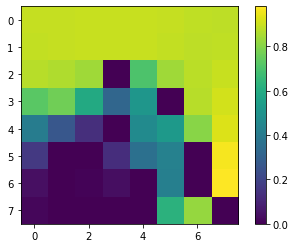

In [33]:
plt.figure()
plt.imshow(V.reshape(8,8))
plt.colorbar()

In [34]:
mean, std = np.mean(V_track, axis=0),  np.std(V_track, axis=0)

<BarContainer object of 64 artists>

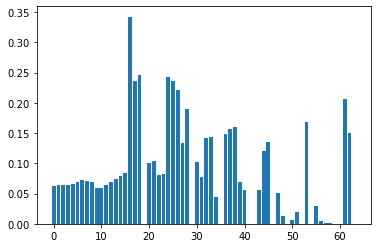

In [35]:
plt.figure()
plt.bar(np.arange(0,std.shape[0]), height=std)

### TD($\lambda$) - Backward view
- Combines both MC and TD(n)
- No need to wait till the end of episode
- Uses the concept of Eligibility traces

#### TD($\lambda$) summary
Every new episode
- set the eligibility trace vector to zero $E(s)=0$
- collect experience based on policy for one step (state, action, reward, next_state, done)
- Increment the eligibility of the starting state by 1, $ E(S_{t}) = E(S_{t}) + 1 $
- Compute the target = $R_{t+1} + \gamma V_{t}(S_{t+1})$
- Compute TD error = target -$ V_{t}(S_{t}) $
- Update all states (not the starting state) $V_{t+1} = V_{t} + \alpha_{t} * TD error * E(s)$
- Decay the Eligibility trace vector, $E_{t+1} = \gamma \lambda E_{t}$

In [3]:
# this function implements the backward view of TD(/lambda)
def TDlambda_prediction(pi, env, gamma=1.0, start_alpha=0.5, min_alpha=0.1, max_episodes=1000, nsteps=1, lambda_=0.3):
    '''
    [1] pi: policy which needs to be evaluated
    [2] env: environment
    [3] gamma: discount factor
    [4] min_alpha: minimum learning rate
    [5] max_episodes: maximum episodes for MC
    [6] nsteps: number of steps in TD, if nsteps=1, then its is TD(0), nsteps=2, then it is TD(1) and so on... 
    [7] lambda_: weight mix-in factor in TD(lambda)
    '''
    nS = len(pi)
    V = np.zeros(nS)
    E = np.zeros(nS) # eligibility trace vector
    V_track = np.zeros((max_episodes, nS)) # value function snapshot  for every episode, just for vis purpose
    
    # generate learning rate schedule 
    alpha_sch = learningrate_schedule(start_alpha, min_alpha, max_episodes) # this will be exponential decay schedule
    
    nS = len(pi)
    V = np.zeros(nS)
    V_track = np.zeros((max_episodes, nS)) # value function snapshot  for every episode, just for vis purpose
    
    # generate learning rate schedule 
    alpha_sch = learningrate_schedule(start_alpha, min_alpha, max_episodes) # this will be exponential decay schedule
    
    for ep in tqdm(range(max_episodes)):
        state, done = env.reset(), False
        E.fill(0) # reset Eligibility for new episode
        while not done:
            E[state] += 1
            action = pi[state]
            next_state, reward, done, info = env.step(action)
            target = reward + gamma * V[next_state] * (not done)
            # update state value for all states based on eligibility
            V = V + alpha_sch[ep] *(target - V[state]) * E
            # decay Eligibility vector
            E  = lambda_ * alpha_sch[ep] * E
            if done:
                break
            state = next_state
            
        V_track[ep,:] = V
              
                
    return V, V_track, alpha_sch    

In [11]:
V, V_track, alpha_sch =TDlambda_prediction(pi, env, gamma=1.0, start_alpha= 1.0, min_alpha=0.1, max_episodes=10_000,\
                                           nsteps=1, lambda_=0.3)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:36<00:00, 103.62it/s]


In [12]:
V

array([0.9278529 , 0.9276958 , 0.92652693, 0.92320542, 0.91623187,
       0.90746373, 0.89638385, 0.89639751, 0.92737072, 0.92762248,
       0.9275655 , 0.92584421, 0.92177089, 0.90920429, 0.89164893,
       0.89421705, 0.89618196, 0.87526067, 0.83023004, 0.        ,
       0.75066289, 0.86306002, 0.8891652 , 0.90483284, 0.86505075,
       0.8213322 , 0.63083935, 0.27147796, 0.5181125 , 0.        ,
       0.87391513, 0.92820689, 0.50651212, 0.42962108, 0.35488867,
       0.        , 0.42890543, 0.50901921, 0.7617069 , 0.94920434,
       0.2813339 , 0.        , 0.        , 0.15758231, 0.30841452,
       0.37472755, 0.        , 0.96377096, 0.12031961, 0.        ,
       0.02146622, 0.04084331, 0.        , 0.33725126, 0.        ,
       0.98368671, 0.08263933, 0.02002209, 0.00582414, 0.        ,
       0.        , 0.52145634, 0.83105213, 0.        ])

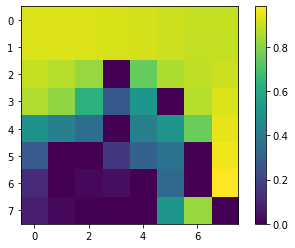

In [13]:
plt.figure()
plt.imshow(V.reshape(8,8))
plt.colorbar()

In [14]:
mean, std = np.mean(V_track, axis=0),  np.std(V_track, axis=0)

<BarContainer object of 64 artists>

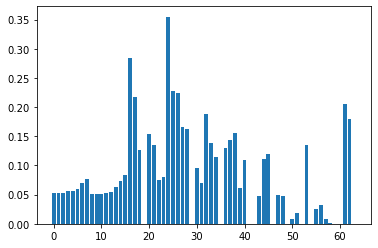

In [15]:
plt.figure()
plt.bar(np.arange(0,std.shape[0]), height=std)